In [1]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree, remove_self_loops
from torch_geometric.utils import softmax as edge_softmax
from torch_geometric.utils import to_networkx
from torch_scatter import scatter

Data(x=[6, 4], edge_index=[2, 8], edge_attr=[8])


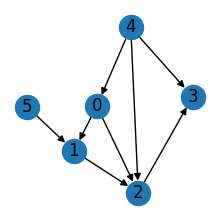

In [2]:
# # 定义图
# edge_index = torch.LongTensor(
#     [
#         [0, 0, 1, 2, 4, 4, 4, 5],
#         [1, 2, 2, 3, 0, 2, 3, 1],
#     ]
# )
# feat = torch.FloatTensor(
#     [
#         [0, 0, 0, 0],
#         [1, 1, 1, 1],
#         [2, 2, 2, 2],
#         [3, 3, 3, 3],
#         [4, 4, 4, 4],
#         [5, 5, 5, 5],
#     ]
# )
# data = Data(x=feat, edge_index=edge_index)
# edge_attr = torch.ones(data.num_edges) * 2
# data.edge_attr = edge_attr

# in_feats = data.num_features
# out_feats = 3

# print(data)
# nxg = to_networkx(data)
# plt.figure(figsize=(2, 2))
# nx.draw(nxg, pos=nx.spring_layout(nxg), with_labels=True)

# Link prediction

## 数据集

In [2]:
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [3]:
device = "cuda"
transform = T.Compose(
    [
        T.NormalizeFeatures(),
        T.ToDevice(device),
        T.RandomLinkSplit(num_test=0.2,num_val=0, add_negative_train_samples=True),
    ]
)
dataset = Planetoid(root="./data/Planetoid", name="CiteSeer", transform=transform)

print(f"Dataset: {dataset}:")
print("======================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6


不拆
- Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


拆但是不加负边
- Data(x=[3327, 3703], edge_index=[2, 7284], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[7284], edge_label_index=[2, 7284])
- Data(x=[3327, 3703], edge_index=[2, 7284], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[1820], edge_label_index=[2, 1820])
- Data(x=[3327, 3703], edge_index=[2, 8194], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[1820], edge_label_index=[2, 1820])


拆且加负边
- Data(x=[3327, 3703], edge_index=[2, 7284], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[14568], edge_label_index=[2, 14568])
- Data(x=[3327, 3703], edge_index=[2, 7284], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[1820], edge_label_index=[2, 1820])
- Data(x=[3327, 3703], edge_index=[2, 8194], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[1820], edge_label_index=[2, 1820])




edge_label=1/0 表示正边和负边<br>
edge_index 是原始图的边<br>
edge_label_index 是加上负边之后的边<br>

```python
positive edge:
 tensor([[1422,  205,   27,  ...,   83, 2126, 1558],
        [2181,  783,  755,  ...,  584,  626, 2331]])
        
negative edge:
 tensor([[ 450, 1854, 3065,  ..., 2952,  529, 1468],
        [1263, 2073,  909,  ...,  502, 1698, 3210]])
```

In [4]:
train_data, val_data, test_data = dataset[0]

## SAGEConv

In [5]:
class mySAGEConv(MessagePassing):
    def __init__(self, in_feats, out_feats):
        super(mySAGEConv, self).__init__(aggr="mean")
        self.W = nn.Linear(2 * in_feats, out_feats, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W.weight)

    def forward(self, x, edge_index):
        hN = self.propagate(edge_index, x=x)
        h_cat = torch.cat([x, hN], dim=1)

        h = self.W(h_cat)
        h = F.normalize(h, dim=1)
        return h

    def message(self, x_j, edge_index):
        return x_j

## SAGE_LP

In [6]:
class SAGE_LP(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super(SAGE_LP, self).__init__()
        self.conv1 = mySAGEConv(in_feats, hid_feats)
        self.conv2 = mySAGEConv(hid_feats, out_feats)

        self.lin1 = nn.Linear(out_feats * 2, out_feats)
        self.lin2 = nn.Linear(out_feats, 1)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin1.weight)
        nn.init.xavier_uniform_(self.lin2.weight)

    def encode(self, x, edge_index):
        # encode 使用edge_index，使用原图的连接信息
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, h, edge_label_index):
        # decode，使用edge_label_index，带有正负边的信息
        src = h[edge_label_index[0]]
        dst = h[edge_label_index[1]]

        h = self.lin1(torch.cat([src, dst], dim=1)).relu()
        h = self.lin2(h)
        return h

    def forward(self, x, edge_index, edge_label_index):
        h = self.encode(x, edge_index)
        return self.decode(h, edge_label_index)

## 训练和测试

In [21]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
)


def test(data):
    with torch.no_grad():
        model.eval()
        logits = model.forward(data.x, data.edge_index, data.edge_label_index).cpu()
        labels = data.edge_label.int().cpu()

        pred = (logits > 0) 

        acc = accuracy_score(pred, labels)
        f1 = f1_score(pred, labels)
        auc = roc_auc_score(labels, logits)

        return acc, f1, auc


def train():
    model.train()
    optimizer.zero_grad()
    logits = model(
        train_data.x, train_data.edge_index, train_data.edge_label_index
    ).squeeze()
    labels = train_data.edge_label

    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()
    return loss

In [12]:
in_feats = train_data.num_features
hid_feats = 128
out_feats = 64

model = SAGE_LP(in_feats, hid_feats, out_feats).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = F.binary_cross_entropy_with_logits

In [13]:
for e in range(101):
    loss = train()
        
    if e % 10 == 0:
        # print(f"epoch {e}, loss: {loss:.6f}, AUC: {test():.6f}")
        print(f"epoch {e}, loss: {loss:.6f}")

epoch 0, loss: 0.693185
epoch 10, loss: 0.456254
epoch 20, loss: 0.268845
epoch 30, loss: 0.126901
epoch 40, loss: 0.050405
epoch 50, loss: 0.019919
epoch 60, loss: 0.009175
epoch 70, loss: 0.005214
epoch 80, loss: 0.003485
epoch 90, loss: 0.002584
epoch 100, loss: 0.002045


In [22]:
print('train: acc, f1, auc: ',test(train_data)) 


train: acc, f1, auc:  (1.0, 1.0, 1.0)


In [23]:
print('train: acc, f1, auc: ',test(test_data)) 

train: acc, f1, auc:  (0.7175824175824176, 0.7110736368746486, 0.7773101074749427)


In [ ]:
# Graph prediction